# Metadata

```yaml
Course:   DS 5001
Module:   10 Lab
Topic:    Word Shift Graphs
Author:   R.C. Alvarado
Date:     02 April 2023 (revised)
```

- See https://ryanjgallagher.github.io/code/word_shift/overview and https://shifterator.readthedocs.io/en/latest/
- See also SocialSent lexicon https://nlp.stanford.edu/projects/socialsent/

# Set Up

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
corpus_prefix = 'austen-melville'

In [3]:
import pandas as pd
import shifterator as sh
import plotly_express as px

In [4]:
import warnings

warnings.filterwarnings("ignore", message="FixedFormatter should only be used together with FixedLocator", category=UserWarning)

# Get Data

In [5]:
SALEX = pd.read_csv(f"{data_home}/lexicons/salex_nrc.csv").set_index('term_str')

In [6]:
SALEX.head()

nrc_anger  nrc_anticipation  nrc_disgust  nrc_fear  nrc_joy  \
term_str                                                                   
abandon              0                 0            0         1        0   
abandoned            1                 0            0         1        0   
abandonment          1                 0            0         1        0   
abduction            0                 0            0         1        0   
aberration           0                 0            1         0        0   

             nrc_negative  nrc_positive  nrc_sadness  nrc_surprise  nrc_trust  \
term_str                                                                        
abandon                 1             0            1             0          0   
abandoned               1             0            1             0          0   
abandonment             1             0            1             1          0   
abduction               1             0            1             1          0   
aberration              1             0            0             0          0   

             nrc_sentiment  
term_str                    
abandon                 -1  
abandoned               -1  
abandonment             -1  
abduction               -1  
aberration              -1

In [7]:
BOW = pd.read_csv(f"{output_dir}/{corpus_prefix}-BOW.csv").set_index(['book_id','chap_num','term_str'])

In [8]:
BOW.head()

n        tf     tfidf
book_id chap_num term_str                       
105     1        1         2  0.000762  0.005084
                 15        1  0.000381  0.003479
                 16        1  0.000381  0.003860
                 1760      1  0.000381  0.003860
                 1784      1  0.000381  0.003860

In [9]:
LIB = pd.read_csv(f"{output_dir}/{corpus_prefix}-LIB_FIXED.csv").set_index(['book_id'])
LIB['author_id'] = LIB.author.str.split(', ').str[0]
LIB['book_label'] = LIB.author_id + ' ' + LIB.index.astype('str') + ': ' + LIB.title.str[:20]

In [10]:
LIB.head()

source_file_path        author  \
book_id                                                                    
105      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
121      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
141      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
158      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
161      ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   

                         title                   chap_regex  book_len  \
book_id                                                                 
105                 PERSUASION              ^Chapter\s+\d+$   83624.0   
121           NORTHANGER ABBEY              ^CHAPTER\s+\d+$   77601.0   
141             MANSFIELD PARK        ^CHAPTER\s+[IVXLCM]+$  160378.0   
158                       EMMA  ^\s*CHAPTER\s+[IVXLCM]+\s*$  160926.0   
161      SENSE AND SENSIBILITY              ^CHAPTER\s+\d+$  119873.0   

         n_chaps                               label  y_raw_2  y_L0_2  y_L1_2  \
book_id                                                                         
105         24.0            Austen: Persuasion (105)        0       1       1   
121         31.0      Austen: Northanger Abbey (121)        0       1       1   
141         48.0        Austen: Mansfield Park (141)        0       1       1   
158         55.0                  Austen: Emma (158)        0       1       1   
161         50.0  Austen: Sense And Sensibilit (161)        0       1       1   

         y_L2_2  y_raw_4  y_L0_4  y_L1_4  y_L2_4  kendall_sum author_id  \
book_id                                                                   
105           1        0       2       2       0     8.275697    AUSTEN   
121           1        0       2       1       0     8.315379    AUSTEN   
141           1        0       2       1       0     8.269857    AUSTEN   
158           1        0       2       1       0     8.224439    AUSTEN   
161           1        0       2       0       0     8.392078    AUSTEN   

                               book_label  
book_id                                    
105                AUSTEN 105: PERSUASION  
121          AUSTEN 121: NORTHANGER ABBEY  
141            AUSTEN 141: MANSFIELD PARK  
158                      AUSTEN 158: EMMA  
161      AUSTEN 161: SENSE AND SENSIBILIT

# Combine Tables

We want to use the word shift diagrams to compare Austen and Melville.

So, we create a table that combines the language models of the two authors along with sentiment values.

In [11]:
AUTH = BOW.join(LIB.author_id, on='book_id')\
    .groupby(['author_id','term_str'])\
    .agg({'n':'sum', 'tfidf':'mean'})\
    .join(SALEX.nrc_sentiment, on='term_str').dropna()

We compute the sentiment contribute of each word for each author.

In [12]:
AUTH['sent_weight'] = AUTH['n'] * AUTH['tfidf'] * AUTH['nrc_sentiment']

In [13]:
AUTH

n     tfidf  nrc_sentiment  sent_weight
author_id term_str                                             
AUSTEN    abandoned     5  0.001951           -1.0    -0.009756
          abhor         7  0.008680           -1.0    -0.060757
          abhorrent     2  0.003221           -1.0    -0.006443
          abolish       1  0.001692           -1.0    -0.001692
          abominable   18  0.002996           -1.0    -0.053927
...                   ...       ...            ...          ...
MELVILLE  young       676  0.001460            1.0     0.986866
          youth       160  0.002918            1.0     0.466892
          zeal         14  0.002857            1.0     0.039997
          zealous       5  0.003010            1.0     0.015051
          zest          4  0.005590            1.0     0.022361

[4866 rows x 4 columns]

In [14]:
AUTH.sent_weight.unstack(fill_value=0).T.sort_values('AUSTEN', ascending=False)\
    .sample(10)\
    .style.background_gradient(cmap='YlGnBu', axis=None)

In [15]:
AUTH.n.unstack().sum()

term_str
abandoned     73.0
abhor         11.0
abhorrent     11.0
abolish        6.0
abominable    36.0
              ... 
wreak          4.0
wrecked       17.0
wrongly        1.0
yell          20.0
zest           4.0
Length: 3076, dtype: float64

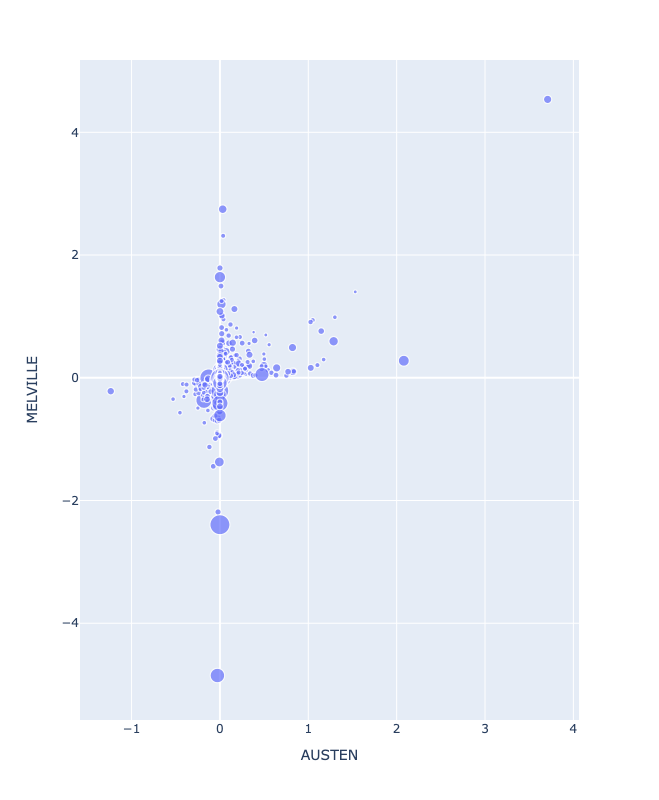

In [16]:
px.scatter(AUTH.sent_weight.unstack(fill_value=0).T.join(AUTH.tfidf.unstack().sum().to_frame('tfidf')).reset_index(), 
           'AUSTEN', 'MELVILLE', 
           size='tfidf',
           hover_name='term_str',
           height=800, width=900)

In [17]:
# AUTH.loc['AUSTEN']

# Frequency Shifts

In [18]:
[item for item in sh.__dir__() if '__' not in item]

['helper',
 'plotting',
 'shifterator',
 'Shift',
 'entropy',
 'shifts',
 'EntropyShift',
 'JSDivergenceShift',
 'KLDivergenceShift',
 'ProportionShift',
 'WeightedAvgShift',
 'name']

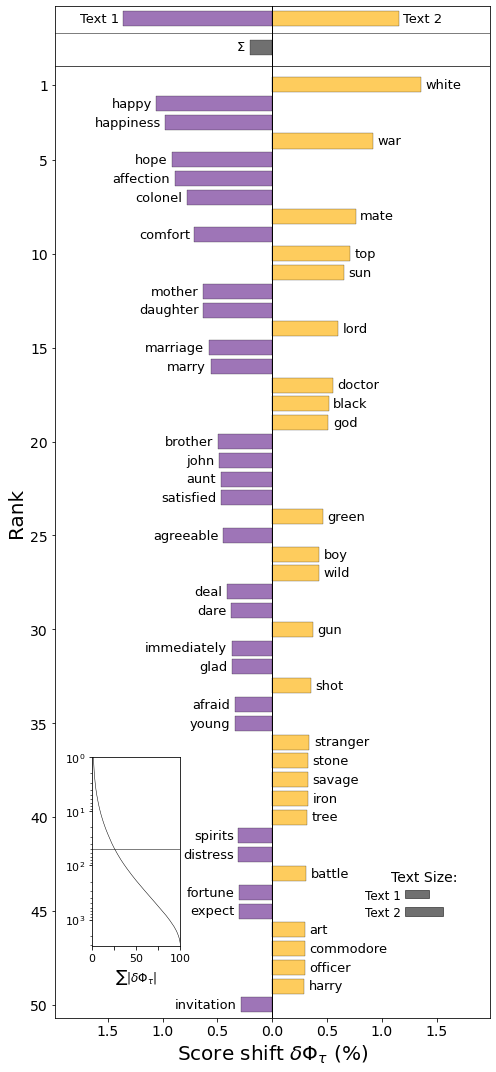

In [19]:
sh.JSDivergenceShift(AUTH.loc['AUSTEN', 'n'].to_dict(), 
                     AUTH.loc['MELVILLE', 'n'].to_dict()).get_shift_graph();

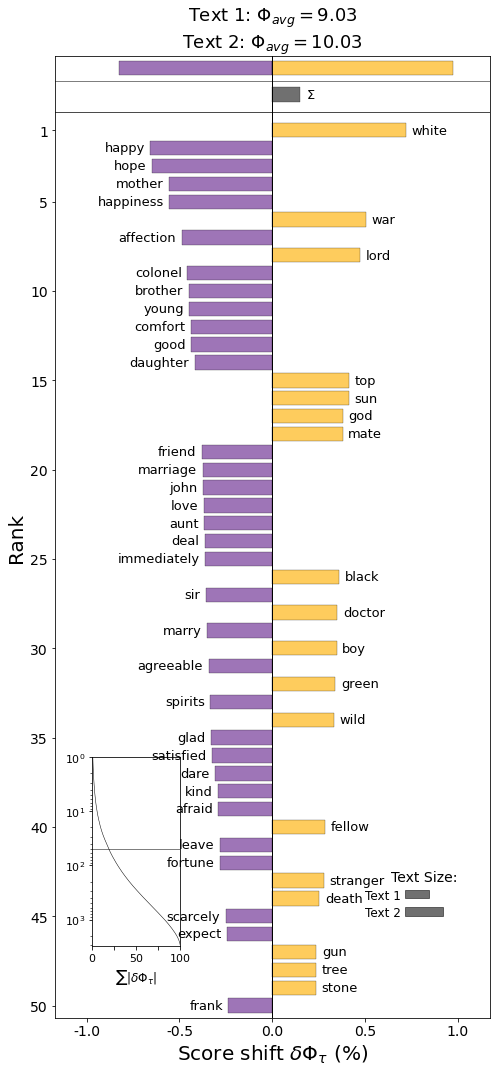

In [20]:
sh.EntropyShift(AUTH.loc['AUSTEN', 'n'].to_dict(), 
                AUTH.loc['MELVILLE', 'n'].to_dict()).get_shift_graph();

In [21]:
FREQ = AUTH.n.unstack().T.dropna()

In [22]:
FREQ

author_id   AUSTEN  MELVILLE
term_str                    
abandoned      5.0      68.0
abhor          7.0       4.0
abhorrent      2.0       9.0
abolish        1.0       5.0
abominable    18.0      18.0
...            ...       ...
yearning       2.0       8.0
young        827.0     676.0
youth         66.0     160.0
zeal          16.0      14.0
zealous        7.0       5.0

[1790 rows x 2 columns]

In [23]:
# SENT = AUTH.nrc_sentiment.unstack().T.dropna()

In [24]:
# SENT

In [25]:
SENTW = AUTH.sent_weight.unstack().T.dropna()

In [26]:
SENTW

author_id     AUSTEN  MELVILLE
term_str                      
abandoned  -0.009756 -0.227710
abhor      -0.060757 -0.009790
abhorrent  -0.006443 -0.030214
abolish    -0.001692 -0.015345
abominable -0.053927 -0.058639
...              ...       ...
yearning    0.000000  0.000000
young       1.300643  0.986866
youth       0.142030  0.466892
zeal        0.028503  0.039997
zealous     0.017088  0.015051

[1790 rows x 2 columns]

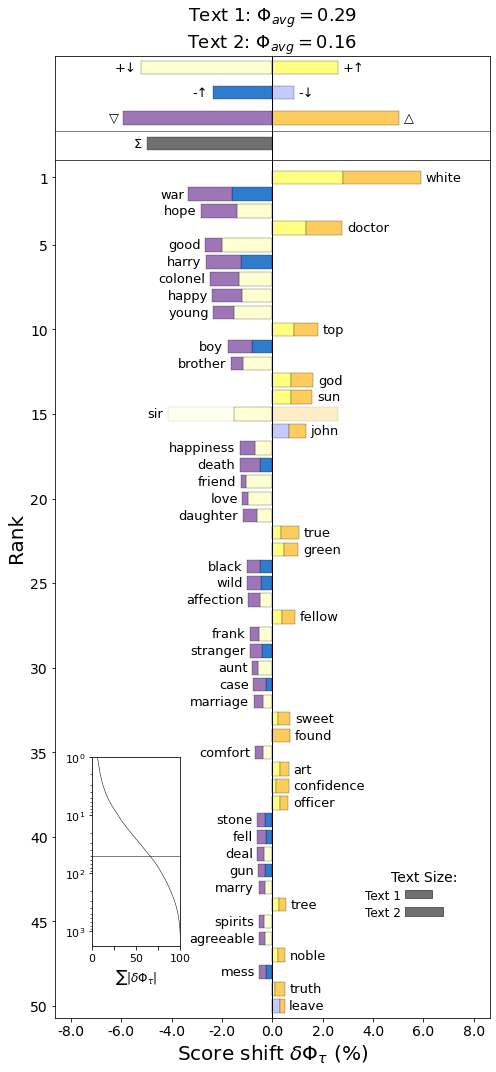

In [27]:
sh.Shift(
    FREQ['AUSTEN'].to_dict(), 
    FREQ['MELVILLE'].to_dict(), 
    SENTW['AUSTEN'].to_dict(), 
    SENTW['MELVILLE'].to_dict()).get_shift_graph();

See https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-021-00260-3

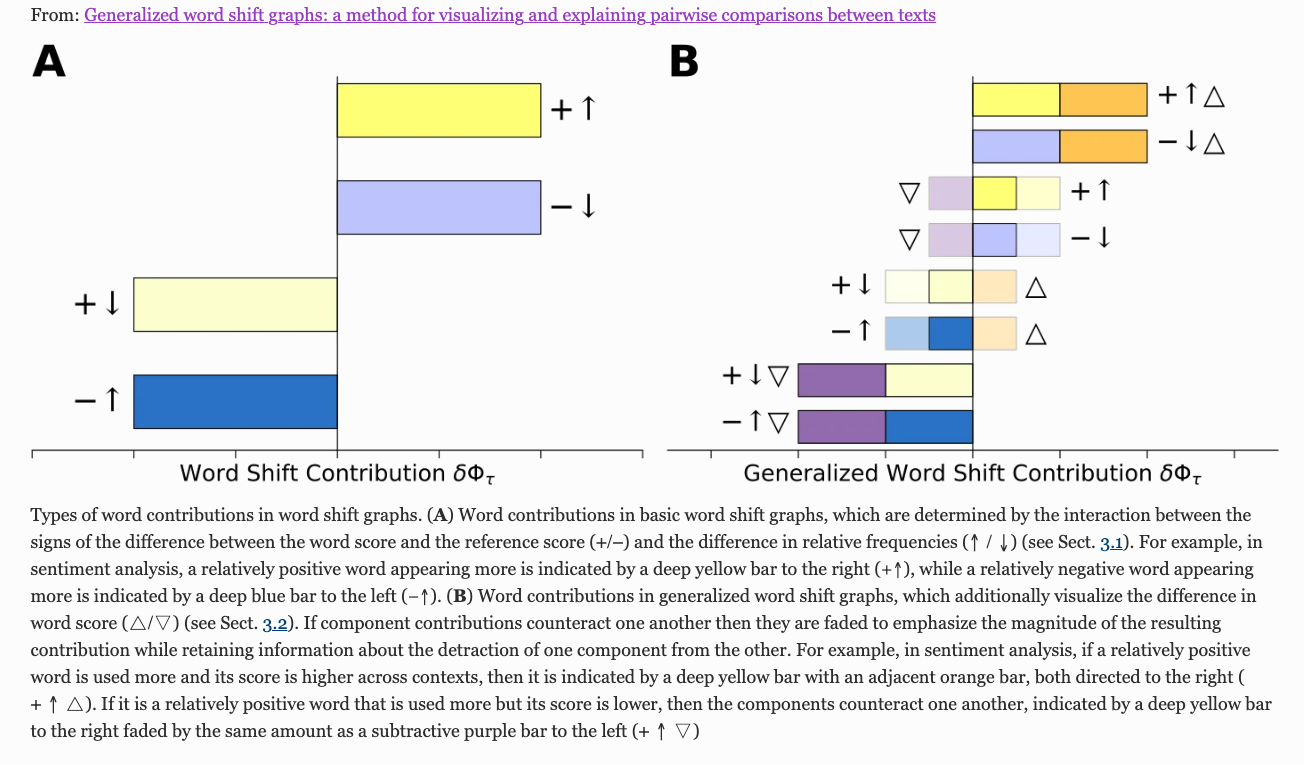

# Topics

In [28]:
PHI = pd.read_csv(f"{output_dir}/{corpus_prefix}-LDA_PHI-40.csv").set_index('topic_id').T
PHI.index.name = 'term_str'

In [29]:
PHI['TSUM'] = PHI.sum(1)

In [30]:
PHIP = PHI / PHI.sum()

In [31]:
PHIP.TSUM

term_str
abbey         0.000104
abhorrence    0.000104
abilities     0.000120
aboard        0.000136
abode         0.000180
                ...   
youngster     0.000066
youth         0.000632
youths        0.000089
zeal          0.000098
zone          0.000060
Name: TSUM, Length: 4000, dtype: float64

In [32]:
def plot_shift(v1, v2):
    sh.EntropyShift(PHIP[v1].to_dict(), PHIP[v2].to_dict()).get_shift_graph()

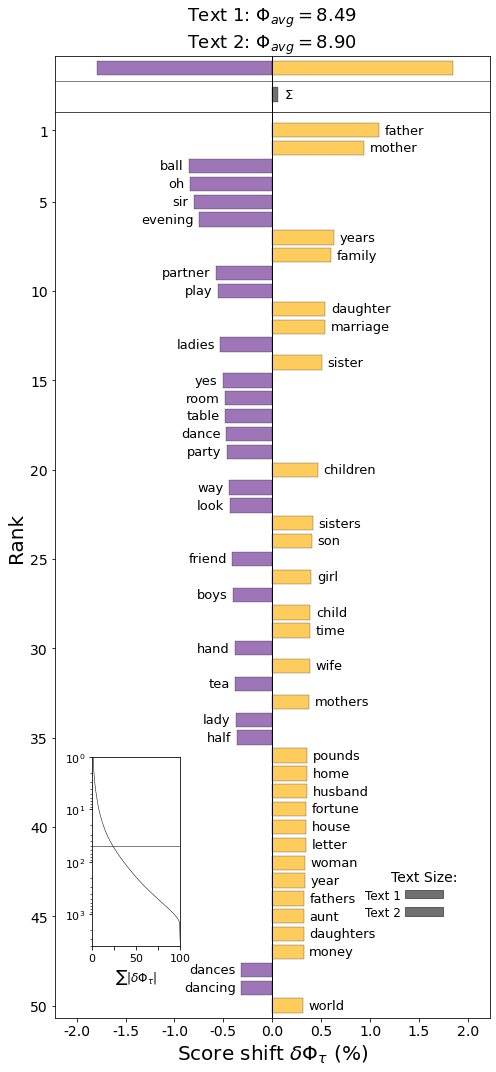

In [33]:
plot_shift('T23', 'T05')